First few lines of raw data:
+,S10,		tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt
+,AMPC,		tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaacgcatcgccaa
+,AROH,		gtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg
+,DEOP2,	aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaatactaacaaactc
+,LEU1_TRNA,	tcgataattaactattgacgaaaagctgaaaaccactagaatgcgcctccgtggtag
+,MALEFG,	aggggcaaggaggatggaaagaggttgccgtataaagaaactagagtccgtttaggt
+,MALK,		cagggggtggaggatttaagccatctcctgatgacgcatagtcagcccatcatgaat
+,RECA,		tttctacaaaacacttga

First few processed data points:
['+,S10,', 'TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT']
['+,AMPC,', 'TGCTATCCTGACAGTTGTCACGCTGATTGGTGTCGTTACAATCTAACGCATCGCCAA']
['+,AROH,', 'GTACTAGAGAACTAGTGCATTAGCTTATTTTTTTGTTATCATGCTAACCACCCGGCG']
['+,DEOP2,', 'AATTGTGATGTGTATCGAAGTGTGTTGCGGAGTAGATGTTAGAATACTAACAAACTC']
['+,LEU1_TRNA,', 'TCGATAATTAACTATTGACGAAAAGCTGAAAACCACTAGAATGCGCCTCCGTGGTAG']

Unique classes in the dataset: {'+,LEU1_TRNA,', '+,RRNG_P1,', '+,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted class for sample sequence: +,BIOB,
Prediction probabilities: [0.02007062 0.00031015 0.00029059 0.01430233 0.00022177 0.01067161
 0.06781875 0.0002004  0.0192513  0.01807559 0.02356926 0.00069921
 0.01482251 0.00015932 0.00680792 0.00022121 0.0084169  0.00026051
 0.02070229 0.00659841 0.01665799 0.01743798 0.03734853 0.00028203
 0.00067428 0.01587389 0.00642508 0.01259856 0.02074263 0.0190298
 0.0144772  0.00042125 0.00032399 0.00090539 0.02396611 0.00033379
 0.03042545 0.01773037 0.00021882 0.03214669 0.01701963 0.01207782
 0.01357291 0.03356975 0.01900304 0.01972972 0.00078334 0.00035576
 0.01109693 0.00039205 0.0055435  0.03503733 0.00081771 0.02887633
 0.00759655 0.03602773 0.00055834 0.00020521 0.03136071 0.03258716
 0.01927711 0.01575624 0.01009499 0.0191174  0.02244014 0.0005957
 0.02076576 0.00055905 0.04131318 0.01354116 0.0288373 ]


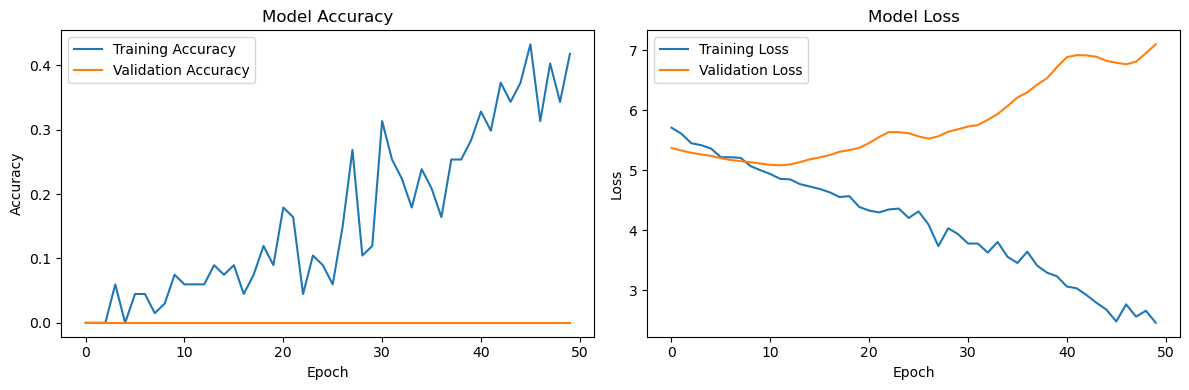

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import requests
from sklearn.utils.class_weight import compute_class_weight

def load_and_preprocess_data(url):
    # Download data
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: HTTP {response.status_code}")
    
    print("First few lines of raw data:")
    print(response.text[:500])
    
    lines = response.text.split('\n')
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            label = parts[0]
            sequence = ''.join(parts[1:]).upper()
            if sequence:
                data.append([label, sequence])
    
    if not data:
        raise Exception("No valid data found after preprocessing")
    
    print("\nFirst few processed data points:")
    for i in range(min(5, len(data))):
        print(data[i])
    
    df = pd.DataFrame(data, columns=['class', 'sequence'])
    
    X = df['sequence'].values
    y = df['class'].values
    
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    X_encoded = np.array([
        [mapping[base] for base in seq if base in mapping]
        for seq in X
    ])
    
    max_length = max(len(seq) for seq in X_encoded)
    X_encoded = np.array([np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 'constant') for seq in X_encoded])
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)
    
    unique_classes = set(label for label, _ in data)
    print(f"\nUnique classes in the dataset: {unique_classes}")

    print("\nExamples of raw data:")
    for i in range(min(5, len(data))):
        print(f"Class: {data[i][0]}, Sequence: {data[i][1][:20]}...")

    print(f"\nLabel encoder classes: {label_encoder.classes_}")

    return X_encoded, y_onehot, label_encoder, y_encoded

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu')(inputs)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

if __name__ == "__main__":
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data"
        X_encoded, y_onehot, label_encoder, y_encoded = load_and_preprocess_data(url)
        
        print(f"\nShape of X_encoded: {X_encoded.shape}")
        print(f"Shape of y_onehot: {y_onehot.shape}")
        
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_onehot, test_size=0.2, random_state=42)
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
        class_weight_dict = dict(enumerate(class_weights))
        
        model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_onehot.shape[1])
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                            class_weight=class_weight_dict, verbose=2)

        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.savefig('training_history.png')
        print("Training history plot saved as 'training_history.png'")

        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test accuracy: {accuracy:.2f}")

        sample_sequence = X_test[0:1]
        prediction = model.predict(sample_sequence)
        predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
        print(f"Predicted class for sample sequence: {predicted_class[0]}")
        print(f"Prediction probabilities: {prediction[0]}")

        model.save('dna_sequence_classifier.keras')

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()